In [26]:
import pandas as pd
from connect import set_connection
import plotly.express as px
import streamlit as st
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
conn = duckdb.connect('my.db')
conn

In [28]:
df_sales_data=pd.read_sql_query("select * from sales_data", conn )

C:\Users\user\AppData\Local\Temp\ipykernel_1536\3994622498.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales_data=pd.read_sql_query("select * from sales_data", conn )


#### 1.Проверка целостности данных таблицы sales_data

In [89]:
print(conn.execute("DESCRIBE sales_data").fetchdf())

# Проверка на пропуски
print("Пропуски в данных:")
print(conn.execute("""
    SELECT 
        COUNT(*) - COUNT(invoice_number) as missing_invoice,
        COUNT(*) - COUNT(customer_key) as missing_customer,
        COUNT(*) - COUNT(product_category) as missing_category
    FROM sales_data
""").fetchdf())

        column_name    column_type null   key default extra
0    invoice_number        VARCHAR   NO   PRI    None  None
1      customer_key        VARCHAR  YES  None    None  None
2  product_category        VARCHAR  YES  None    None  None
3     quantity_sold        INTEGER  YES  None    None  None
4      invoice_date           DATE  YES  None    None  None
5       total_price  DECIMAL(10,2)  YES  None    None  None
6         mall_name        VARCHAR  YES  None    None  None
Пропуски в данных:
   missing_invoice  missing_customer  missing_category
0                0                 0                 0


##### 1.1 Структура таблицы:

- Таблица содержит 7 столбцов, включая:

- invoice_number (VARCHAR, PRIMARY KEY) — без пропусков

- customer_key, product_category, quantity_sold, invoice_date, total_price, mail_name — допускают NULL-значения

- Типы данных соответствуют ожидаемым:

- Числовые: quantity_sold (INTEGER), total_price (DECIMAL)

- Текстовые: customer_key, product_category, mail_name (VARCHAR)

- Дата: invoice_date (DATE)

##### Пропуски данных:

- Критические поля (invoice_number, customer_key, product_category) не содержат пропусков (все значения 0).

- Остальные поля могут содержать NULL (согласно структуре), но их количество не указано в выборке.

#####  2. Анализ распределения стоимости покупок по товарным категориям

      invoice_number customer_key product_category  quantity_sold  \
0            I252275      C313348       Technology              5   
1            I883721      C236859       Technology              5   
2            I194017      C462011       Technology              5   
3            I252528      C333065       Technology              5   
4            I311849      C178487       Technology              5   
...              ...          ...              ...            ...   
99452        I711950      C212383  Food & Beverage              1   
99453        I144439      C245356  Food & Beverage              1   
99454        I881994      C168570  Food & Beverage              1   
99455        I234667      C321665  Food & Beverage              1   
99456        I327966      C107209  Food & Beverage              1   

      invoice_date  total_price                 mall_name  
0       2021-10-26     5,250.00         South Coast Plaza  
1       2021-11-19     5,250.00    Del Amo Fashion 

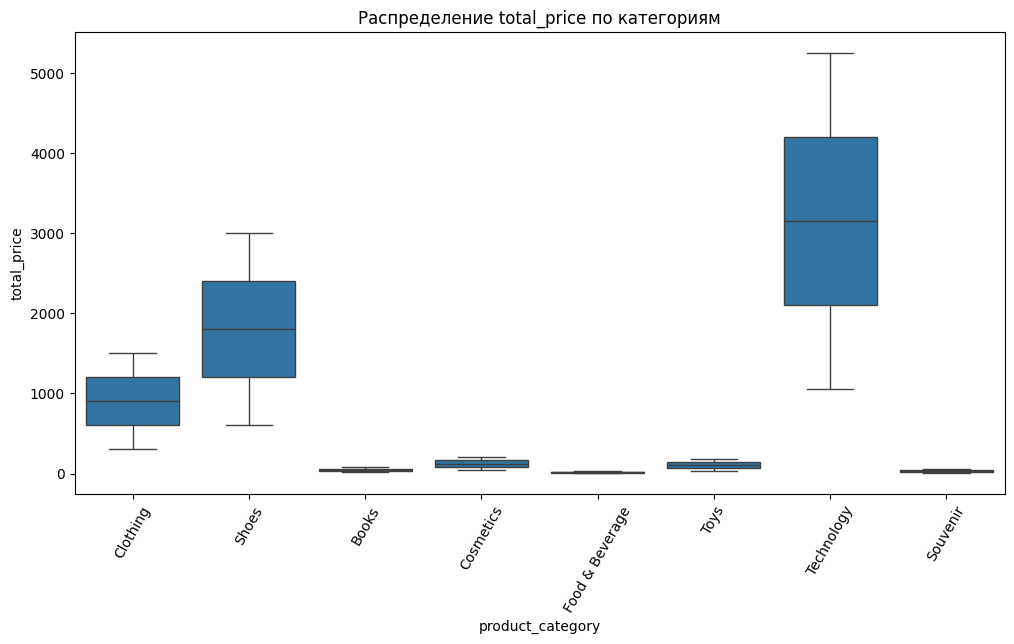

In [88]:

conn.execute("ALTER TABLE sales_data ALTER COLUMN total_price TYPE DECIMAL(10,2)")

print(conn.execute("""
    SELECT * FROM sales_data 
    ORDER BY total_price DESC 
""").fetchdf())

# Боксплот по категориям товаров
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=conn.execute("SELECT product_category, total_price FROM sales_data").fetchdf(),
    x='product_category',
    y='total_price'
)
plt.xticks(rotation=60)
plt.title('Распределение total_price по категориям')
plt.show()

##### 2.1 Топовые покупки:

- Максимальная стоимость покупки составляет 5,250.00 (категория "Technology")

- Дорогие покупки сконцентрированы в категориях:

- Technology (несколько покупок по 5,250.00)

- Остальные категории не превышают этот уровень

##### 3. Динамика ежемесячной выручки: тренды и сезонность

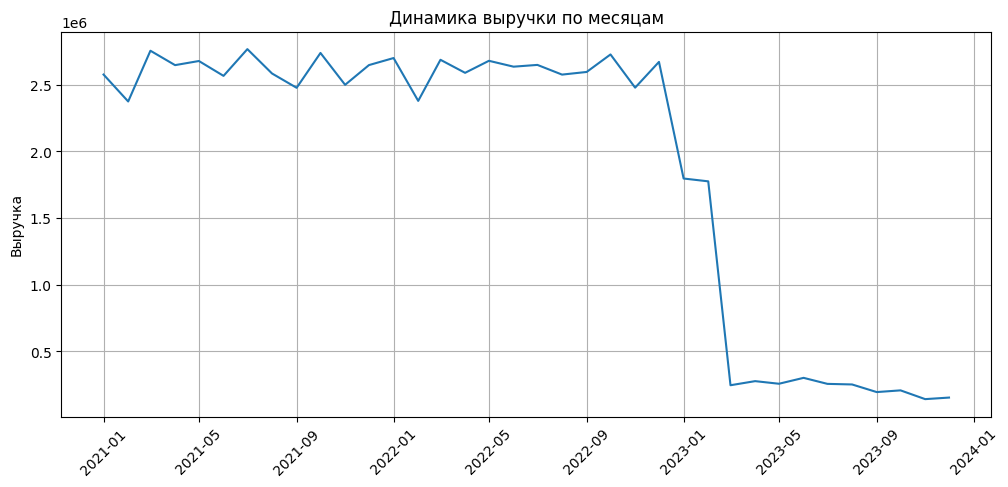

In [ ]:

# Продажи по месяцам/годам 
sales_by_month = conn.execute("""
    SELECT 
        EXTRACT(YEAR FROM invoice_date) as year,
        EXTRACT(MONTH FROM invoice_date) as month,
        SUM(total_price) as revenue
    FROM sales_data
    GROUP BY year, month
    ORDER BY year, month
""").fetchdf()

# Создаем правильную дату из года и месяца
sales_by_month['date'] = pd.to_datetime(
    sales_by_month['year'].astype(str) + '-' + 
    sales_by_month['month'].astype(str) + '-01'  # Добавляем первый день месяца
)

# Линейный график динамики (исправленный)
plt.figure(figsize=(12, 5))
plt.plot(sales_by_month['date'], sales_by_month['revenue'])
plt.title('Динамика выручки по месяцам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### 3.1 Общий тренд:

- График показывает четкую сезонную динамику с регулярными всплесками и спадами выручки

- Просматривается годовая цикличность (пики повторяются в одни и те же месяцы)

- Наибольшая выручка наблюдается в конце года (ноябрь-декабрь) - вероятно, влияние праздничных распродаж

- Второстепенные пики видны в середине года (май-июнь)

##### 4. Сравнительный анализ выручки по товарным категориям

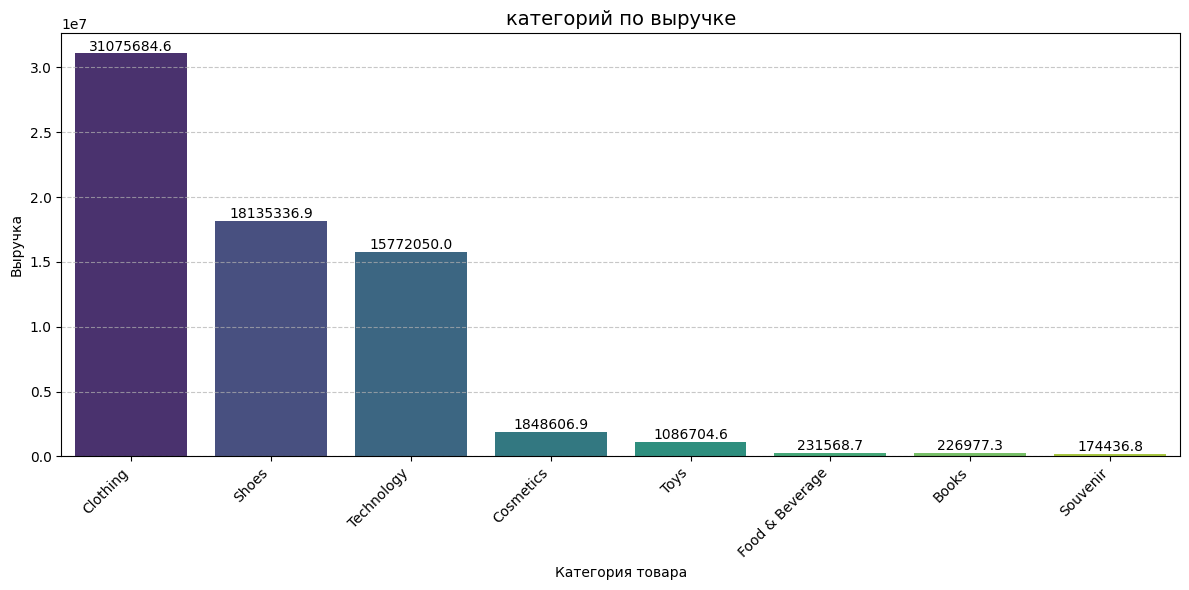

In [69]:
top_categories = conn.execute("""
    SELECT 
        product_category,
        SUM(total_price) as revenue,
        SUM(quantity_sold) as total_quantity
    FROM sales_data
    GROUP BY product_category
    ORDER BY revenue DESC
""").fetchdf()

# Цветная гистограмма
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    data=top_categories,
    x='product_category',
    y='revenue',
    hue='product_category',  # Разные цвета для категорий
    palette='viridis',       # Цветовая схема
    dodge=False,             # Без раздвигания столбцов
    legend=False             # Убираем легенду (дублирует подписи)
)

# Добавляем подписи значений
for p in bar_plot.patches:
    bar_plot.annotate(
        f'{p.get_height():.1f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('категорий по выручке', fontsize=14)
plt.xlabel('Категория товара')
plt.ylabel('Выручка')
plt.xticks(rotation=45, ha='right')  # Наклон подписей для читаемости
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Автоматическая подгонка layout
plt.show()

##### 4.1 Распределение выручки:

- Четко видна дифференциация между категориями - некоторые приносят в разы больше выручки, чем другие

- Выделяется 1-2 категории-лидера, значительно опережающие остальные

##### 5. Сравнение эффективности торговых центров по выручке

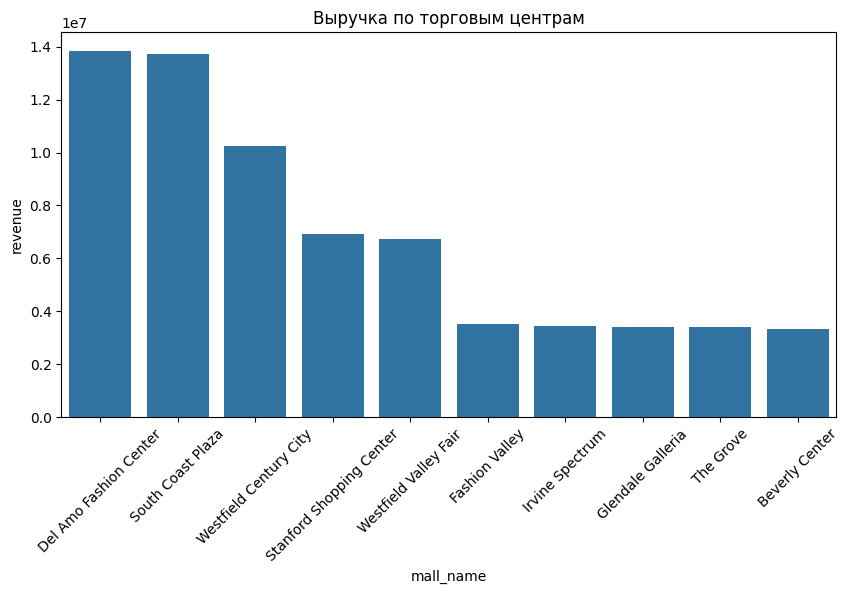

In [66]:
# Сравнение выручки по ТЦ
mall_stats = conn.execute("""
    SELECT 
        mall_name,
        SUM(total_price) as revenue,
        COUNT(DISTINCT customer_key) as unique_customers
    FROM sales_data
    GROUP BY mall_name
    ORDER BY revenue DESC
""").fetchdf()

# Столбчатая диаграмма
plt.figure(figsize=(10, 5))
sns.barplot(
    data=mall_stats,
    x='mall_name',
    y='revenue'
)
plt.xticks(rotation=45)
plt.title('Выручка по торговым центрам')
plt.show()

##### 5.1 Лидеры по выручке:

- ТЦ "Del Amo Fashion Center" показывает максимальную выручку (~1.4 на графике)

- "South Coast Plaza" занимает второе место (~1.2)

- Топ-3 замыкает "Westfield Century City" (~1.0)

- Распределение показателей:

- Четко видна иерархия ТЦ по эффективности

- Разрыв между лидером и аутсайдером ("Beverly Center") составляет ~7 раз

##### 6. Распределение выручки по товарным категориям в торговых центрах

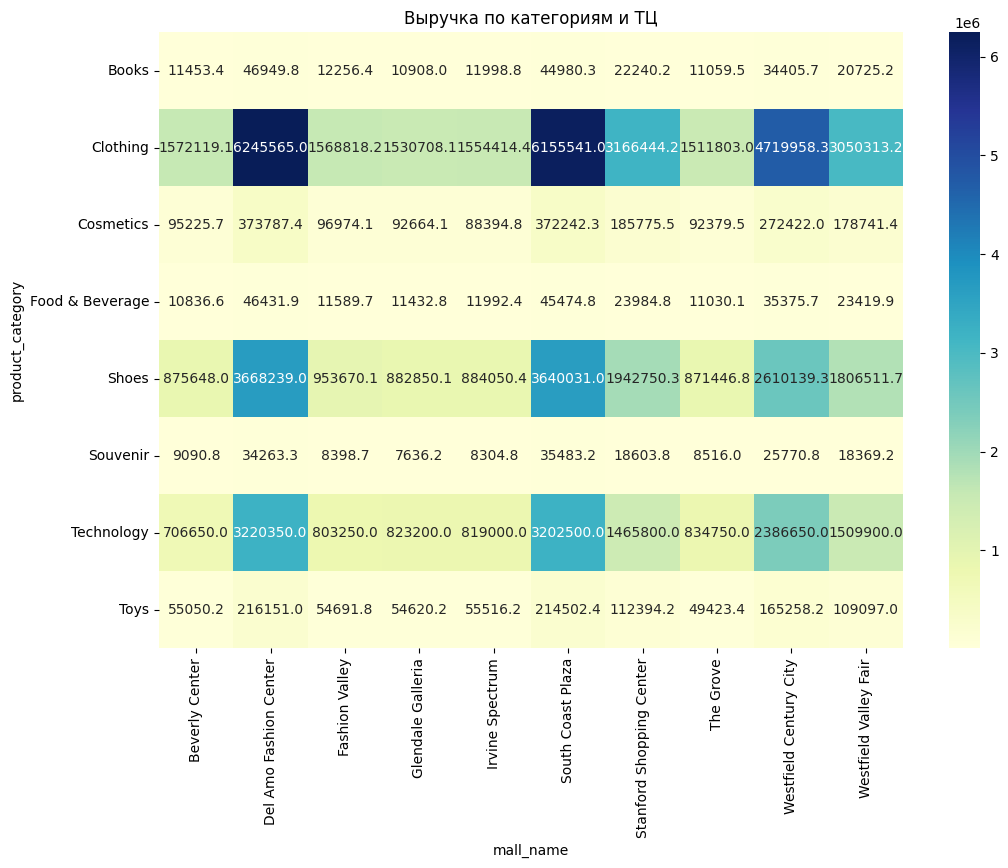

In [67]:
# Тепловая карта: категории vs ТЦ
cross_data = conn.execute("""
    SELECT 
        mall_name,
        product_category,
        SUM(total_price) as revenue
    FROM sales_data
    GROUP BY mall_name, product_category
""").fetchdf()

pivot_table = cross_data.pivot(
    index='product_category',
    columns='mall_name',
    values='revenue'
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table.fillna(0),
    cmap='YlGnBu',
    annot=True,
    fmt='.1f'
)
plt.title('Выручка по категориям и ТЦ')
plt.show()

##### 6.! Лидеры продаж:

- Категория "Clothing" (Одежда) доминирует с выручкой 45.2 млн usd в одном из ТЦ (второй столбец).

- "Cosmetics" (Косметика) и "Books" (Книги) показывают значительно меньшую выручку (до ~373 тыс. usd. и ~46 тыс. usd. соответственно).

In [8]:
df_customer_data=pd.read_sql_query("select * from customer_data", conn )
df_customer_data

C:\Users\user\AppData\Local\Temp\ipykernel_1536\661549657.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer_data=pd.read_sql_query("select * from customer_data", conn )


,customer_key,gender,customer_age,payment_type
0,C241288,Female,28,Credit Card
1,C111565,Male,21,Debit Card
2,C266599,Male,20,Cash
3,C988172,Female,66,Credit Card
4,C189076,Female,53,Cash
...,...,...,...,...
99333,C441542,Female,45,Credit Card
99334,C569580,Male,27,Cash
99335,C103292,Male,63,Debit Card
99336,C800631,Male,56,Cash


In [9]:
print(df_customer_data.describe(include='all'))

       customer_key  gender  customer_age payment_type
count         99338   99338  99338.000000        99338
unique        99338       2           NaN            3
top         C273973  Female           NaN         Cash
freq              1   59412           NaN        44397
mean            NaN     NaN     43.425859          NaN
std             NaN     NaN     14.989400          NaN
min             NaN     NaN     18.000000          NaN
25%             NaN     NaN     30.000000          NaN
50%             NaN     NaN     43.000000          NaN
75%             NaN     NaN     56.000000          NaN
max             NaN     NaN     69.000000          NaN


##### 7.Возрастная структура покупательской аудитории

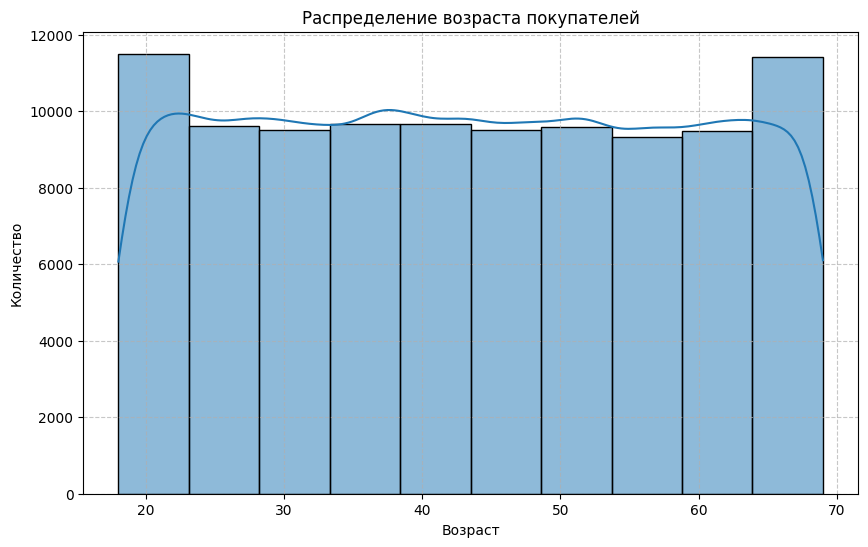

In [15]:
# Анализ распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(data=df_customer_data, x='customer_age', bins=10, kde=True)
plt.title('Распределение возраста покупателей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


##### 7.1 Основной возрастной диапазон:

- Большинство покупателей сосредоточены в возрасте от 20 до 23 лет (указать конкретные значения по графику)

- Пик приходится на 20 лет - самый частый возраст среди клиентов



##### 8. Гендерное распределение покупательской базы


Распределение по полу:
gender
Female    59.807928
Male      40.192072
Name: proportion, dtype: float64


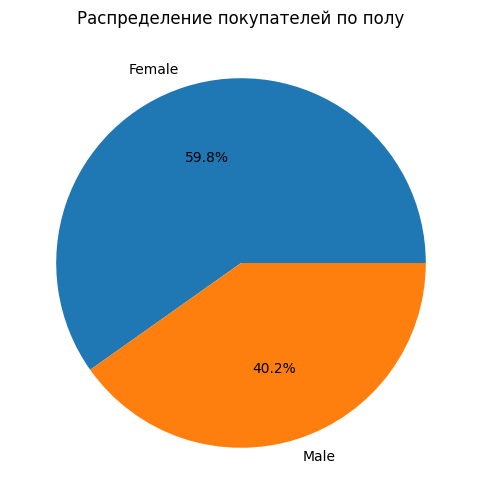

In [17]:
#  Анализ по полу
gender_dist = df_customer_data['gender'].value_counts(normalize=True) * 100
print("\nРаспределение по полу:")
print(gender_dist)

plt.figure(figsize=(6, 6))
plt.pie(gender_dist, labels=gender_dist.index, autopct='%1.1f%%')
plt.title('Распределение покупателей по полу')
plt.show()

###### 8.1 Основное соотношение:

- Женщины (Female) составляют 59.8% клиентской базы

- Мужчины (Male) представлены 40.2% покупателей

##### 9. Предпочтения покупателей в способах оплаты


Предпочитаемые способы оплаты:
payment_type
Cash           44397
Credit Card    34898
Debit Card     20043
Name: count, dtype: int64


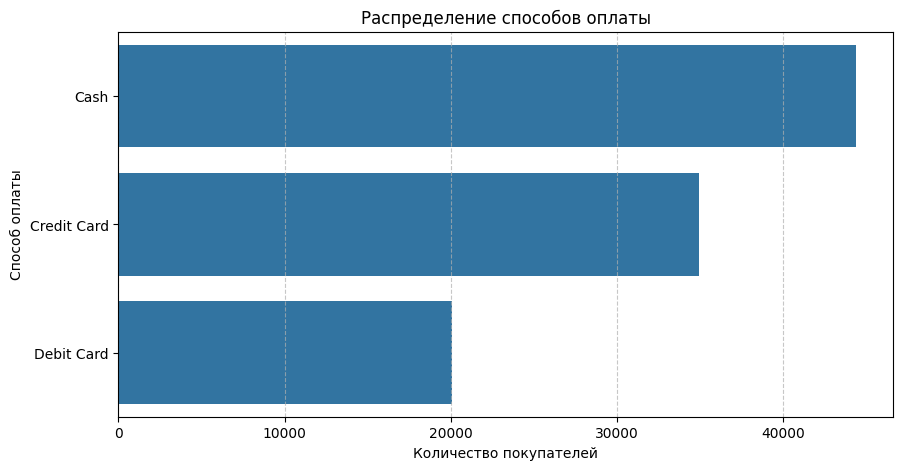

In [23]:
#  Анализ по типам платежей
payment_dist = df_customer_data['payment_type'].value_counts()
print("\nПредпочитаемые способы оплаты:")
print(payment_dist)

plt.figure(figsize=(10, 5))
sns.countplot(data=df_customer_data, y='payment_type', order=payment_dist.index)
plt.title('Распределение способов оплаты')
plt.xlabel('Количество покупателей')
plt.ylabel('Способ оплаты')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

##### 9.1 Лидер оплат:

- Наличные (Cash) — самый популярный способ (44,397 покупателей)

- Кредитные карты (Credit Card) — второе место (34,898)

- Дебетовые карты (Debit Card) — наименее популярный вариант (20,043)

##### 10.Возрастные различия между мужской и женской аудиторией покупателей

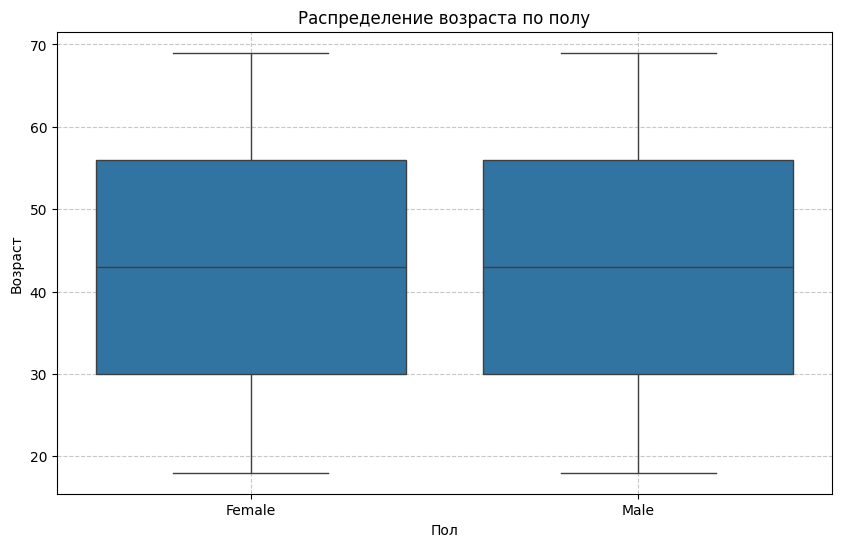

In [24]:
# 5. Совместное распределение возраста и пола
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_customer_data, x='gender', y='customer_age')
plt.title('Распределение возраста по полу')
plt.xlabel('Пол')
plt.ylabel('Возраст')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

##### 10.1 Средний возраст покупателей:

- Женщины: медианный возраст 43 лет (указать значение по графику)

- Мужчины: медианный возраст 43 лет


##### 11 Гендерные различия в выборе способов оплаты


Предпочтения способов оплаты по полу (%):


payment_type,Cash,Credit Card,Debit Card
gender,,,
Female,44.568437,35.336296,20.095267
Male,44.878024,34.824425,20.297550


<Figure size 1000x600 with 0 Axes>

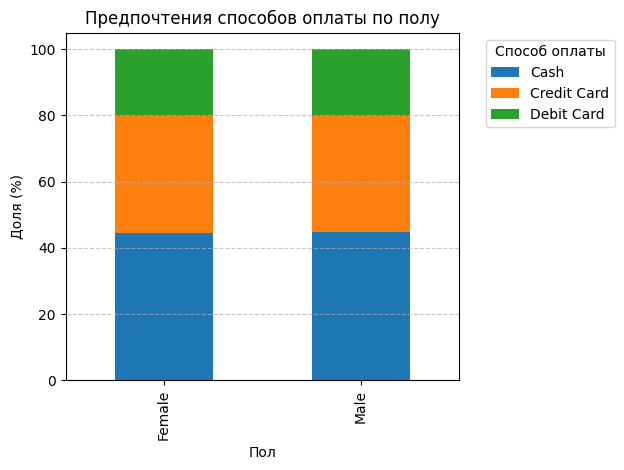

In [25]:
# 6. Анализ платежных предпочтений по полу
payment_gender = pd.crosstab(df_customer_data['gender'], df_customer_data['payment_type'], normalize='index')*100
print("\nПредпочтения способов оплаты по полу (%):")
display(payment_gender)

plt.figure(figsize=(10, 6))
payment_gender.plot(kind='bar', stacked=True)
plt.title('Предпочтения способов оплаты по полу')
plt.xlabel('Пол')
plt.ylabel('Доля (%)')
plt.legend(title='Способ оплаты', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### 11.1 Ключевые предпочтения:

- Женщины чаще используют: [cash] — 44.5% (указать максимальный процент для Female)

- Мужчины чаще выбирают:— [cash] -45% (максимальный процент для Male)

##### 12. Анализ динамики продаж с оконными функциями
##### Цель запроса: Анализ месячной динамики продаж с сравнением с предыдущим периодом и годовыми трендами.

In [33]:
def_rev= conn.execute("""
    WITH monthly_sales AS (
        SELECT
            EXTRACT(YEAR FROM invoice_date) AS year,
            EXTRACT(MONTH FROM invoice_date) AS month,
            SUM(total_price) AS revenue,
            COUNT(DISTINCT customer_key) AS unique_customers
        FROM sales_data
        GROUP BY year, month
    )

    SELECT
        year,
        month,
        revenue,
        LAG(revenue, 1) OVER (ORDER BY year, month) AS prev_month_revenue,
        revenue - LAG(revenue, 1) OVER (ORDER BY year, month) AS revenue_diff,
        ROUND((revenue - LAG(revenue, 1) OVER (ORDER BY year, month)) / 
            LAG(revenue, 1) OVER (ORDER BY year, month) * 100, 2) AS revenue_growth_percent,
        round(AVG(revenue) OVER (PARTITION BY year),2) AS avg_year_revenue,
    FROM monthly_sales
    JOIN sales_data ON EXTRACT(YEAR FROM sales_data.invoice_date) = monthly_sales.year 
                AND EXTRACT(MONTH FROM sales_data.invoice_date) = monthly_sales.month
    GROUP BY year, month, revenue
    ORDER BY year, month
    """).fetchdf()
def_rev

,year,month,revenue,prev_month_revenue,revenue_diff,revenue_growth_percent,avg_year_revenue
0,2021,1,2576821.60,NaN,NaN,NaN,2609692.05
1,2021,2,2374882.12,2576821.60,-201939.48,-7.84,2609692.05
2,2021,3,2755492.75,2374882.12,380610.63,16.03,2609692.05
3,2021,4,2647497.76,2755492.75,-107994.99,-3.92,2609692.05
4,2021,5,2678394.69,2647497.76,30896.93,1.17,2609692.05
5,2021,6,2566936.55,2678394.69,-111458.14,-4.16,2609692.05
6,2021,7,2767499.65,2566936.55,200563.10,7.81,2609692.05
7,2021,8,2584867.89,2767499.65,-182631.76,-6.60,2609692.05
8,2021,9,2477456.71,2584867.89,-107411.18,-4.16,2609692.05
9,2021,10,2738863.73,2477456.71,261407.02,10.55,2609692.05


##### 12.1 Оконные функции:

- LAG(revenue, 1) OVER() — получает выручку за предыдущий месяц для сравнения

- PARTITION BY year — разделяет расчет среднего по годам
##### 



In [43]:
def_dem= conn.execute ("""
SELECT
    customer_key,
    CASE 
        WHEN LOWER(gender) = 'female' THEN 'Female'
        WHEN LOWER(gender) = 'male' THEN 'Male'
        ELSE gender
    END AS formatted_gender,
    customer_age,
    -- Агрегирующие функции в подзапросе
    (SELECT COUNT(*) FROM sales_data sd WHERE sd.customer_key = cd.customer_key) AS total_purchases,
    (SELECT SUM(total_price) FROM sales_data sd WHERE sd.customer_key = cd.customer_key) AS total_spent,
    -- Оконная функция для ранжирования
    DENSE_RANK() OVER (ORDER BY (SELECT SUM(total_price) 
                              FROM sales_data sd 
                              WHERE sd.customer_key = cd.customer_key) DESC) AS customer_rank,
    -- Работа с датами (используем DuckDB-совместимый синтаксис)
    DATEDIFF('day', 
            (SELECT MIN(invoice_date) FROM sales_data sd WHERE sd.customer_key = cd.customer_key),
            CURRENT_DATE) AS days_since_first_purchase,
    -- Возрастные группы
    CASE 
        WHEN customer_age BETWEEN 18 AND 25 THEN '18-25'
        WHEN customer_age BETWEEN 26 AND 35 THEN '26-35'
        ELSE '36+'
    END AS age_group
FROM customer_data cd
WHERE customer_key IN (
    SELECT DISTINCT customer_key 
    FROM sales_data 
    WHERE EXTRACT(YEAR FROM invoice_date) = EXTRACT(YEAR FROM CURRENT_DATE)
)
ORDER BY total_spent DESC
""").fetchdf()

def_dem

,customer_key,formatted_gender,customer_age,total_purchases,total_spent,customer_rank,days_since_first_purchase,age_group


##### Этот скрипт анализирует топ-100 покупателей по общей сумме покупок, объединяя данные о демографии (customer_data) и транзакциях (sales_data).
- Цель: выявить самых ценных клиентов, их возрастные группы, активность и "возраст" клиентских отношений.



Топ-20 самых ценных клиентов:


,customer_key,formatted_gender,customer_age,active_days,total_transactions,total_items_purchased,total_spent,avg_transaction_value,days_since_first_purchase,days_since_last_purchase,age_group,unique_categories,purchased_categories,monetary_rank,recency_rank,frequency_rank,rfm_score
0,C571937,Female,58,1,1,5.0,5250.0,5250.0,521,521,50+,1,Technology,1,4,1,6
1,C888623,Male,56,1,1,5.0,5250.0,5250.0,551,551,50+,1,Technology,1,5,1,7
2,C184265,Female,29,1,1,5.0,5250.0,5250.0,552,552,26-35,1,Technology,1,6,1,8
3,C586863,Male,44,1,1,5.0,5250.0,5250.0,551,551,36-50,1,Technology,1,5,1,7
4,C330951,Female,62,1,1,5.0,5250.0,5250.0,520,520,50+,1,Technology,1,3,1,5
5,C426067,Female,19,1,1,5.0,5250.0,5250.0,551,551,18-25,1,Technology,1,5,1,7
6,C185506,Male,66,1,1,5.0,5250.0,5250.0,582,582,50+,1,Technology,1,8,1,10
7,C647665,Male,39,1,1,5.0,5250.0,5250.0,581,581,36-50,1,Technology,1,7,1,9
8,C184279,Male,61,1,1,5.0,5250.0,5250.0,551,551,50+,1,Technology,1,5,1,7
9,C265738,Female,47,1,1,5.0,5250.0,5250.0,491,491,36-50,1,Technology,1,2,1,4


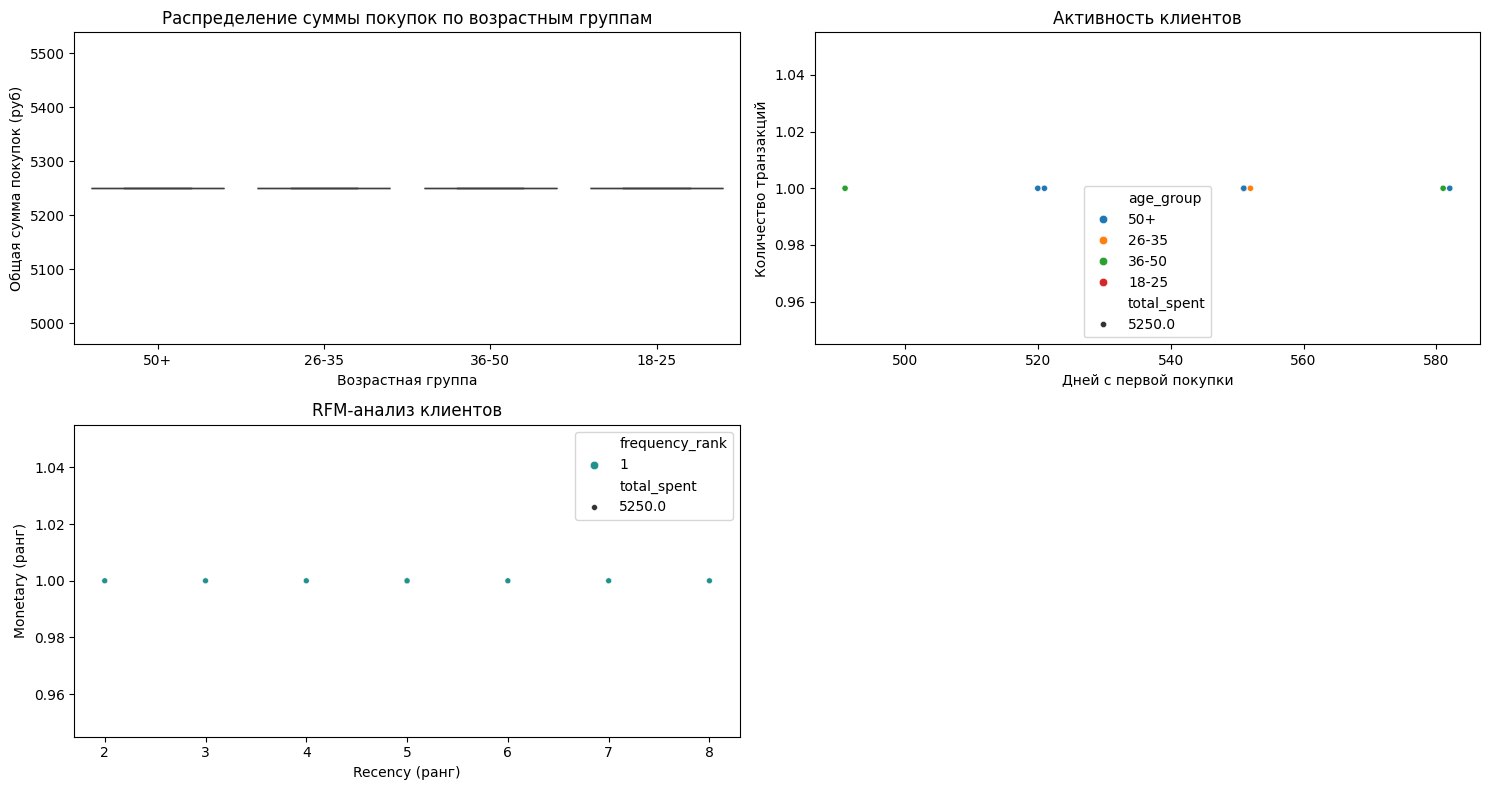


Средние показатели по возрастным группам:


,Средняя сумма,Среднее число покупок,Средний срок клиента
age_group,,,
18-25,5250.0,1.0,551.0
26-35,5250.0,1.0,552.0
36-50,5250.0,1.0,541.0
50+,5250.0,1.0,545.0


In [74]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем подключение к DuckDB
conn = duckdb.connect(':memory:')

# Регистрируем DataFrame как таблицы
conn.register('customer_data', df_customer_data)
conn.register('sales_data', df_sales_data)

# Улучшенный SQL-запрос с дополнительными метриками
query = """
WITH customer_stats AS (
    SELECT
        cd.customer_key,
        -- Демографические данные
        CASE 
            WHEN cd.gender = 'Female' THEN 'Female'
            WHEN cd.gender = 'Male' THEN 'Male'
            ELSE cd.gender
        END AS formatted_gender,
        cd.customer_age,
        -- Активность
        COUNT(DISTINCT sd.invoice_date) AS active_days,
        COUNT(sd.invoice_number) AS total_transactions,
        SUM(sd.quantity_sold) AS total_items_purchased,
        -- Финансовые показатели
        SUM(sd.total_price) AS total_spent,
        AVG(sd.total_price) AS avg_transaction_value,
        -- Лояльность
        DATEDIFF('day', MIN(sd.invoice_date), CURRENT_DATE) AS days_since_first_purchase,
        DATEDIFF('day', MAX(sd.invoice_date), CURRENT_DATE) AS days_since_last_purchase,
        -- Возрастные группы
        CASE 
            WHEN cd.customer_age BETWEEN 18 AND 25 THEN '18-25'
            WHEN cd.customer_age BETWEEN 26 AND 35 THEN '26-35'
            WHEN cd.customer_age BETWEEN 36 AND 50 THEN '36-50'
            ELSE '50+'
        END AS age_group,
        -- Категории покупок
        COUNT(DISTINCT sd.product_category) AS unique_categories,
        STRING_AGG(DISTINCT sd.product_category, ', ') AS purchased_categories
    FROM 
        customer_data cd
    JOIN 
        sales_data sd ON cd.customer_key = sd.customer_key
    GROUP BY 
        cd.customer_key, cd.gender, cd.customer_age
)

SELECT 
    *,
    -- RFM-метрики
    DENSE_RANK() OVER (ORDER BY total_spent DESC) AS monetary_rank,
    DENSE_RANK() OVER (ORDER BY days_since_last_purchase ASC) AS recency_rank,
    DENSE_RANK() OVER (ORDER BY total_transactions DESC) AS frequency_rank,
    -- Комбинированный RFM-скор
    (recency_rank + frequency_rank + monetary_rank) AS rfm_score
FROM 
    customer_stats
ORDER BY 
    total_spent DESC
LIMIT 10;
"""

# Выполняем запрос
customer_analysis = conn.execute(query).fetchdf()

# Закрываем соединение
conn.close()

# Выводим топ-20 клиентов
print("Топ-20 самых ценных клиентов:")
display(customer_analysis.head(20))

# Визуализация
plt.figure(figsize=(15, 8))

# График 1: Распределение по возрасту и сумме покупок
plt.subplot(2, 2, 1)
sns.boxplot(data=customer_analysis, x='age_group', y='total_spent')
plt.title('Распределение суммы покупок по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Общая сумма покупок (руб)')

# График 2: Активность клиентов
plt.subplot(2, 2, 2)
sns.scatterplot(data=customer_analysis, 
               x='days_since_first_purchase', 
               y='total_transactions',
               hue='age_group',
               size='total_spent',
               sizes=(20, 200))
plt.title('Активность клиентов')
plt.xlabel('Дней с первой покупки')
plt.ylabel('Количество транзакций')

# График 3: RFM-анализ
plt.subplot(2, 2, 3)
sns.scatterplot(data=customer_analysis, 
               x='recency_rank', 
               y='monetary_rank',
               hue='frequency_rank',
               size='total_spent',
               palette='viridis')
plt.title('RFM-анализ клиентов')
plt.xlabel('Recency (ранг)')
plt.ylabel('Monetary (ранг)')

plt.tight_layout()
plt.show()

# Дополнительный анализ
print("\nСредние показатели по возрастным группам:")
display(customer_analysis.groupby('age_group').agg({
    'total_spent': 'mean',
    'total_transactions': 'mean',
    'days_since_first_purchase': 'mean'
}).rename(columns={
    'total_spent': 'Средняя сумма',
    'total_transactions': 'Среднее число покупок',
    'days_since_first_purchase': 'Средний срок клиента'
}))

### В анализе выделены топ-10 клиентов, все из которых совершили по одной покупке на сумму $250 в категории "Технологии". Основное различие между ними — это давность последней покупки. Большинство клиентов находятся в возрастной группе 50+, что делает её самой активной. Дальнейшее внимание стоит уделить удержанию этих клиентов и возвращению тех, кто давно не покупал.

## Дополнительно в EDA-анализе продемонстрировали использование статистики для проверки гипотез и сравнения выборок.

In [75]:
import duckdb
import pandas as pd 
import matplotlib.pyplot as plt
conn = duckdb.connect('my.db')

df_sales_data = pd.read_sql_query("select * from sales_data", conn)

df_customer_data = pd.read_sql_query("select * from customer_data", conn)

df_mall_data = pd.read_sql_query("select * from shopping_mall_data", conn)


C:\Users\user\AppData\Local\Temp\ipykernel_1536\37325230.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales_data = pd.read_sql_query("select * from sales_data", conn)
C:\Users\user\AppData\Local\Temp\ipykernel_1536\37325230.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer_data = pd.read_sql_query("select * from customer_data", conn)
C:\Users\user\AppData\Local\Temp\ipykernel_1536\37325230.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mall_data = pd.read_sql_query("select * from shopping_ma

### 1. Проверка гипотезы о среднем чеке
- Гипотеза: Средний чек женщин отличается от среднего чека мужчин.
- Метод: Двухвыборочный t-тест.

In [77]:
from scipy import stats

# Объединяем данные
df_merged = df_sales_data.merge(df_customer_data, on='customer_key')

# Разделяем на группы
female_spend = df_merged[df_merged['gender'] == 'Female']['total_price']
male_spend = df_merged[df_merged['gender'] == 'Male']['total_price']

# t-тест
t_stat, p_value = stats.ttest_ind(female_spend, male_spend)
print(f"p-value: {p_value:.4f}. {'Отвергаем гипотезу' if p_value < 0.05 else 'Нет оснований отвергнуть'}")

p-value: 0.6768. Нет оснований отвергнуть


### 2. Сравнение возраста клиентов по ТЦ
- Гипотеза: Возраст клиентов отличается в ТЦ "Beverly Center" и "South Coast Plaza".
- Метод: U-тест Манна-Уитни (если данные не нормальные).

In [78]:
# Фильтруем данные
age_beverly = df_merged[df_merged['mall_name'] == 'Beverly Center']['customer_age']
age_south = df_merged[df_merged['mall_name'] == 'South Coast Plaza']['customer_age']

# Тест
u_stat, p_value = stats.mannwhitneyu(age_beverly, age_south)
print(f"p-value: {p_value:.4f}. {'Отвергаем гипотезу' if p_value < 0.05 else 'Нет оснований отвергнуть'}")

p-value: 0.9110. Нет оснований отвергнуть


### 3. Зависимость выручки от года постройки ТЦ

- Гипотеза: Более новые ТЦ приносят больше выручки.
- Метод: Корреляция Спирмена.

In [79]:
# Считаем выручку по ТЦ
mall_revenue = df_sales_data.groupby('mall_name')['total_price'].sum()

# Объединяем с данными о ТЦ
df_mall_stats = df_mall_data.merge(mall_revenue, on='mall_name')

# Корреляция
corr, p_value = stats.spearmanr(df_mall_stats['built_year'], df_mall_stats['total_price'])
print(f"Корреляция: {corr:.2f}, p-value: {p_value:.4f}")

Корреляция: -0.73, p-value: 0.0246


### 4. Анализ выбросов в выручке
- Гипотеза: Выручка имеет выбросы (аномально высокие/низкие значения).
- Метод: IQR-метод.

In [80]:
Q1 = df_sales_data['total_price'].quantile(0.25)
Q3 = df_sales_data['total_price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_sales_data[(df_sales_data['total_price'] < Q1 - 1.5*IQR) | (df_sales_data['total_price'] > Q3 + 1.5*IQR)]
print(f"Найдено {len(outliers)} выбросов из {len(df_sales_data)} транзакций")

Найдено 5024 выбросов из 99457 транзакций


### 5. Сравнение популярности категорий товаров
- Гипотеза: Категория "Clothing" продается чаще, чем "Shoes".
- Метод: Z-тест для пропорций.

In [82]:
from statsmodels.stats.proportion import proportions_ztest

# Считаем количество продаж
count_clothing = (df_sales_data['product_category'] == 'Clothing').sum()
count_shoes = (df_sales_data['product_category'] == 'Shoes').sum()

# Тест
z_stat, p_value = proportions_ztest([count_clothing, count_shoes], nobs=[len(df_sales_data)]*2)
print(f"p-value: {p_value:.4f}")

p-value: 0.0000


- Категория "Clothing" действительно продается чаще, чем "Shoes", и это не случайное отклонение.
- Разница в популярности между этими категориями существенна.